In [1]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from abc import ABC, abstractmethod

class Agent(ABC):
    @abstractmethod
    def observe(self,state,action, next_state, reward):
    #call upon observing a new transtition of the environment
        pass

    @abstractmethod
    def select_action(self, state):
    #pick an action from the given state
        pass
        
    @abstractmethod  
    def update(self):
    #called after each environment step. This is wgere all the training takes place
        pass



Episode reward after taking random actions: -200.0


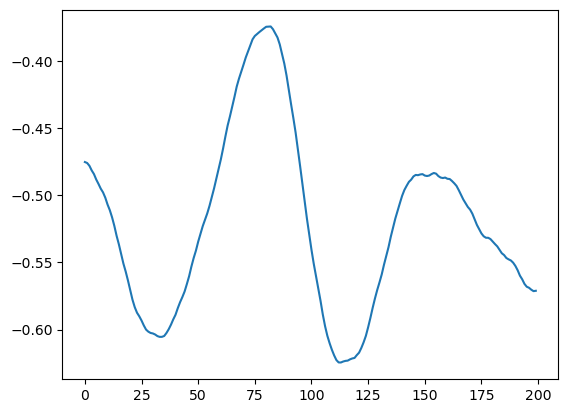

In [34]:
class RandomAgent:
    
    def select_action(self, state, env):
        return env.action_space.sample()
    
    def update(self, state, env):
        action = self.select_action(state, env)
        next_state, reward,terminated, truncated, _  = env.step(action)
        done = terminated or truncated

        return next_state,reward,done,

env = gym.make('MountainCar-v0')
random_agent = RandomAgent()
rewards = np.zeros(n_episodes)

state,_ = env.reset()
reward_epi = 0
done = False
x=[]
while not done:
    next_state,reward,end=random_agent.update(state, env)
    reward_epi += reward
    state=next_state
    x.append(state[0])
    done=end


env.close()

print(f"Episode reward after taking random actions: {reward_epi}")
plt.plot(x)

In [2]:
class DynaAgent:
    def __init__(self, n_states, n_actions, discr_step=[0.025, 0.005], gamma=0.99, epsilon=0.9, min_epsilon=0.05, k=5):
        self.discr_step = discr_step
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.k = k
        
        self.n_states_x = n_states[0]
        self.n_states_v=n_states[1]
        self.n_states=self.n_states_x*self.n_states_v
        self.n_actions = n_actions
        
        # Initialize model components
        self.P_hat = np.ones(shape=(self.n_states, self.n_actions, self.n_states) )/ self.n_states
        self.R_hat = np.zeros(shape=(self.n_states, self.n_actions))
        self.Q = np.zeros(shape=(self.n_states, self.n_actions))
        
    def discretize_state(self, state):
        discr_state = (state + np.array([1.2, 0.07])) / np.array(self.discr_step)
        return tuple(discr_state.astype(int))
        
    def encode_state(self,state):
        return state[0]+self.n_states_x*state[1]
    
    def update_model(self, state, action, reward, next_state):
        discr_state = self.discretize_state(state)
        discr_next_state = self.discretize_state(next_state)
        
        # Update transition probabilities
        self.P_hat[self.encode_state(discr_state)][action][self.encode_state(discr_next_state)] += 1
        
        # Update rewards
        self.R_hat[self.encode_state(discr_state)][action] += reward
    
    def update_q_value(self, state, action, reward, next_state):
        
        discr_state = self.discretize_state(state)
        discr_next_state = self.discretize_state(next_state)

        current=self.encode_state(discr_state)
        next=self.encode_state(discr_next_state)

        # Update Q-value
        max_next_q_value = np.max(self.Q[next])
        self.Q[current][action] = self.R_hat[current][action] + self.gamma * max_next_q_value
    
    def update(self, state, action, reward, next_state):
        
        self.update_model(state, action, reward, next_state)
        self.update_q_value(state, action, reward, next_state)
        
        # Perform further updates for k randomly chosen state-action pairs
        for _ in range(self.k):
            rand_state = np.array([random.uniform(-1.2, 0.6),random.uniform(-0.07, 0.07)])
            rand_state=np.round(rand_state, 2)
            rand_action = np.random.randint(self.n_actions)
            self.update_q_value(rand_state, rand_action, self.R_hat[self.encode_state(self.discretize_state(rand_state))][rand_action], rand_state)
    
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            discr_state = self.discretize_state(state)
            return np.argmax(self.Q[self.encode_state(discr_state)])
    
    def decay_epsilon(self, episode):
        self.epsilon = max(self.min_epsilon, self.epsilon * (0.99 ** episode))

In [5]:

# Create the environment
env = gym.make('MountainCar-v0')

# Get the number of states and actions
n_states = tuple(((env.observation_space.high - env.observation_space.low) / np.array([0.025, 0.005])).astype(int) + 1)
n_actions = env.action_space.n
# Create the DynaAgent
dyna_agent = DynaAgent(n_states=n_states, n_actions=n_actions)

# Train the agent
n_episodes = 30
episode_durations = []

for episode in range(n_episodes):
    state,_ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = dyna_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        dyna_agent.update(state, action, reward, next_state)
        done= terminated or truncated
        state = next_state
        total_reward += reward
    
    episode_durations.append(total_reward)
    dyna_agent.decay_epsilon(episode)

env.close()

# Analyze results and create necessary plots
# Code for analyzing and plotting the results would go here
